# 銀河のぼんやり白いもの（Colab版 / v2）

Colabでそのまま動くようにした版です。  
**回帰 → カウント（ポアソン） → 不確実性 → 外れ値 →（おまけで）PyTorch**まで、ひと続きで試せます。

- `u`：銀河帯の位置（中心に近いほど“厚い”想定）
- `overlap`：レンズの重なり（鮮明さ）
- `star_count`：見える星の数（カウント）
- `haze_obs`：ぼんやり白さ（連続値）
- `memo`：本文由来の観測メモ（雰囲気担当）

> 合言葉：深呼吸してから検証する（まず観測条件を疑う）


In [17]:
!git clone https://github.com/Mokafe/ginga-ml-uncertainty-public.git
%cd ginga-ml-uncertainty-public


Cloning into 'ginga-ml-uncertainty-public'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 45 (delta 15), reused 36 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 59.10 KiB | 1008.00 KiB/s, done.
Resolving deltas: 100% (15/15), done.
/content/ginga-ml-uncertainty-public/ginga-ml-uncertainty-public


In [18]:
# Colab向け：必要なものをインストール
# （Colabには大体入っていますが、バージョン差が出ないように明示します）
!pip -q install -U scikit-learn matplotlib plotly

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, PoissonRegressor, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_poisson_deviance

import plotly.express as px
import plotly.graph_objects as go


## 1) データの用意

次のどれかでOKです：

- **A. リポジトリを Colab で開いてる場合**：`data/ginga_galaxy_haze_v2.csv` があれば自動で読みます  
- **B. 手元のCSVをアップロード**：次のセルでアップロードして読みます  
- **C. GitHubのrawから取る**：URLを書き換えて `pd.read_csv(url)` で読みます（サンプル用）


In [19]:
import os
from google.colab import files

# A) repo内にある想定パス（必要に応じて変えてOK）
CANDIDATES = [
    "data/ginga_galaxy_haze_v2.csv",
    "ginga_galaxy_haze_v2.csv",
    "ginga_galaxy_haze_v2_sample.csv",
    "data/sample/ginga_galaxy_haze_v2_sample.csv",
]

csv_path = None
for p in CANDIDATES:
    if os.path.exists(p):
        csv_path = p
        break

if csv_path is None:
    print("CSVが見つかりません。アップロードします（A/B/CのB）。")
    up = files.upload()  # ここでCSVを選ぶ
    csv_path = list(up.keys())[0]

print("Using:", csv_path)
df = pd.read_csv(csv_path)
df.head(5)


Using: data/sample/ginga_galaxy_haze_v2_sample.csv


,obs_id,observer,instrument,t_index,u,overlap,thickness_true,depth_blue,memo,f_white,...,f_light,f_star,f_len,haze_obs,star_count,true_lambda,noise_sigma,overdispersed,event_flag,event_name
0,5,カムパネルラ,両面凸レンズ模型,62,0.356735,0.989074,0.915705,0.478939,けれどもだんだん気をつけて見ると、そのきれいな水は、ガラスよりも水素よりもすきとおって、とき...,0,...,2,0,160,1.166294,2,2.618564,0.103246,0,0,NaN
1,31,カムパネルラ,両面凸レンズ模型,141,-0.995758,0.206107,0.565045,0.392944,と思ったら、もう次から次から、たくさんのきいろな底をもったりんどうの花のコップが、湧（わ）く...,0,...,1,0,96,0.696609,1,0.963325,0.278939,1,0,NaN
2,34,ジョバンニ,両面凸レンズ模型,231,-0.975189,0.793893,0.555068,0.390566,川下の向う岸に青く茂（しげ）った大きな林が見え、その枝（えだ）には熟してまっ赤に光る円い実が...,0,...,1,0,140,0.759732,0,1.283837,0.149721,0,0,NaN
3,45,先生,アルビレオ両面凸レンズ,55,-0.486645,0.933013,0.658242,0.415383,「天の川の水あかりに、十日もつるして置くかね、そうでなけぁ、砂に三四日うずめなけぁいけないんだ,0,...,0,0,47,0.717809,4,1.857291,0.118122,0,0,NaN
4,52,先生,両面凸レンズ模型,18,-0.342159,0.345492,0.937959,0.484495,ね、きれいでしょう、あんなに光っています,0,...,1,0,20,1.011170,0,1.898159,0.244612,0,0,NaN


## 2) まず眺める（窓景色の“統計”）

- 分布（ヒストグラム）
- `u` と `overlap` と目的変数の関係（散布図）


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 35211 (\N{CJK UNIFIED IDEOGRAPH-898B}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 12360 (\N{HIRAGANA LETTER E}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 12427 (\N{HIRAGANA LETTER RU}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 26143 (\N{CJK UNIFIED IDEOGRAPH-661F}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.



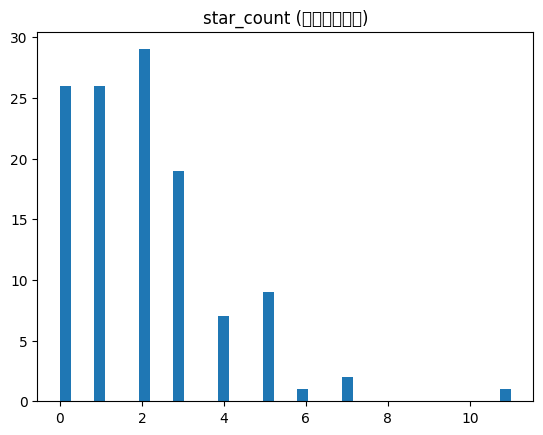

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 12412 (\N{HIRAGANA LETTER BO}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 12435 (\N{HIRAGANA LETTER N}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 12420 (\N{HIRAGANA LETTER YA}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 12426 (\N{HIRAGANA LETTER RI}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 30333 (\N{CJK UNIFIED IDEOGRAPH-767D}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 12373 (\N{HIRAGANA LETTER SA}) missing from font(s) DejaVu Sans.



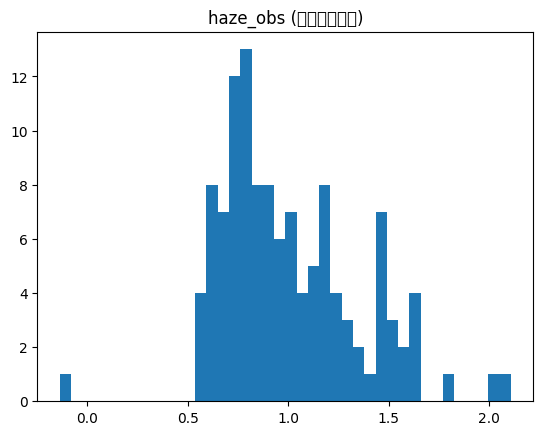

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 12524 (\N{KATAKANA LETTER RE}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 12474 (\N{KATAKANA LETTER ZU}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 12394 (\N{HIRAGANA LETTER NA}) missing from font(s) DejaVu Sans.



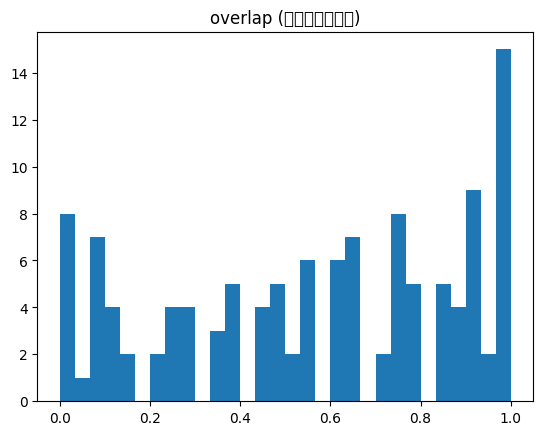

In [20]:
# ヒストグラム（matplotlib）
fig, ax = plt.subplots()
ax.hist(df["star_count"], bins=40)
ax.set_title("star_count (見える星の数)")
plt.show()

fig, ax = plt.subplots()
ax.hist(df["haze_obs"], bins=40)
ax.set_title("haze_obs (ぼんやり白さ)")
plt.show()

fig, ax = plt.subplots()
ax.hist(df["overlap"], bins=30)
ax.set_title("overlap (レンズの重なり)")
plt.show()


In [21]:
# インタラクティブ散布図（plotly）
# u vs haze_obs（色＝overlap）
fig = px.scatter(df, x="u", y="haze_obs", color="overlap",
                 hover_data=["star_count","memo"],
                 title="u vs haze_obs (color=overlap)")
fig.show()

# u vs star_count（色＝overlap）
fig = px.scatter(df, x="u", y="star_count", color="overlap",
                 hover_data=["haze_obs","memo"],
                 title="u vs star_count (color=overlap)")
fig.show()


## 3) 特徴量づくり：中心ほど厚い → `u^2` を入れる

In [22]:
df2 = df.copy()
df2["u2"] = df2["u"]**2

base_cols = ["u","u2","overlap","depth_blue","f_white","f_blue","f_light","f_star","f_len"]
X_base = df2[base_cols]


## 4) ぼんやり白さ（連続）を回帰で説明する

まずはシンプルに線形回帰。  
係数を見て「何が白さに効いてそう？」を物語っぽく言葉にしてみます。


In [23]:
y = df2["haze_obs"]
Xtr, Xte, ytr, yte = train_test_split(X_base, y, test_size=0.25, random_state=0)

lin = LinearRegression().fit(Xtr, ytr)
pred = lin.predict(Xte)
print("LinearRegression MSE (haze):", mean_squared_error(yte, pred))

coef = pd.Series(lin.coef_, index=X_base.columns).sort_values(ascending=False)
coef


LinearRegression MSE (haze): 0.067422721198533


,0
depth_blue,2.047597
overlap,0.099489
f_white,0.021974
f_star,0.011910
f_len,0.000624
f_light,-0.011644
f_blue,-0.017612
u,-0.054173
u2,-0.154171


## 5) 交互作用：青×白（depth_blueの活用）＋多重共線性の気配

「青さが深いと、白いぼんやりが打ち消される/変形されるのでは？」という仮説で、交互作用を入れてみます。

- `depth_blue * f_white`
- `depth_blue * overlap`
- `overlap * f_white`

増やすと楽しいけど、解釈が難しくなったり推定が不安定になったりするのも論点。


In [24]:
df2["blue_x_white"] = df2["depth_blue"] * df2["f_white"]
df2["blue_x_overlap"] = df2["depth_blue"] * df2["overlap"]
df2["overlap_x_white"] = df2["overlap"] * df2["f_white"]

cols = base_cols + ["blue_x_white","blue_x_overlap","overlap_x_white"]
X = df2[cols]
y = df2["haze_obs"]

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=0)

lin2 = LinearRegression().fit(Xtr, ytr)
pred2 = lin2.predict(Xte)
print("LinearRegression MSE (haze, +interaction):", mean_squared_error(yte, pred2))

pd.Series(lin2.coef_, index=X.columns).sort_values(ascending=False)


LinearRegression MSE (haze, +interaction): 0.06360188902182844


,0
blue_x_overlap,1.824092
depth_blue,0.961863
overlap_x_white,0.170914
f_white,0.119788
f_blue,0.002310
f_star,0.001426
f_len,0.000667
f_light,-0.021613
u,-0.038502
u2,-0.185757


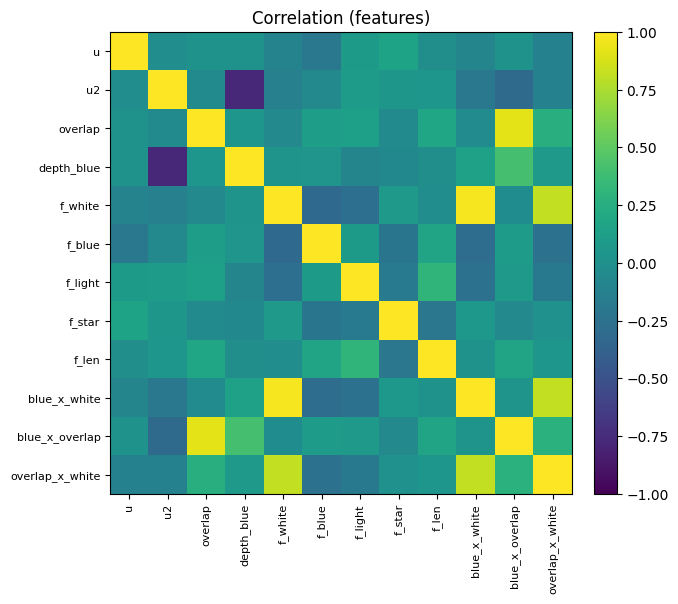

condition number: 14.32624894905881


In [25]:
# 相関（ざっくり）と条件数（大きいほど不安定になりがち）
corr = pd.DataFrame(X).corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(7,6))
im = ax.imshow(corr.to_numpy(), vmin=-1, vmax=1)
ax.set_xticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90, fontsize=8)
ax.set_yticks(range(len(corr.columns)))
ax.set_yticklabels(corr.columns, fontsize=8)
ax.set_title("Correlation (features)")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.show()

Xs = StandardScaler().fit_transform(X)
cond = np.linalg.cond(Xs)
print("condition number:", cond)


In [26]:
# Lasso（選ぶ）と Ridge（安定化）で比較
lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=0, max_iter=20000))
lasso.fit(Xtr, ytr)
pred_l = lasso.predict(Xte)
print("Lasso MSE:", mean_squared_error(yte, pred_l))

ridge = make_pipeline(StandardScaler(), RidgeCV(alphas=np.logspace(-3,3,30), cv=5))
ridge.fit(Xtr, ytr)
pred_r = ridge.predict(Xte)
print("Ridge MSE:", mean_squared_error(yte, pred_r))

coef_l = pd.Series(lasso.named_steps["lassocv"].coef_, index=X.columns).sort_values(ascending=False)
coef_l


Lasso MSE: 0.058839045202195336
Ridge MSE: 0.06476941263488589


,0
depth_blue,0.181902
blue_x_overlap,0.023791
overlap_x_white,0.004480
overlap,0.000000
f_star,-0.000000
f_light,-0.000000
f_white,0.000000
f_blue,-0.000000
blue_x_white,0.000000
f_len,0.000000


## 6) 「ぼんやり」＝観測ノイズ：overlapで分散が変わるか？

overlapが小さい（レンズが重ならない）ほど、滲みが増えて観測が不安定になるはず。


In [27]:
tmp = df2.copy()
tmp["over_bin"] = pd.qcut(tmp["overlap"], q=6, duplicates="drop")
g = tmp.groupby("over_bin")["haze_obs"].agg(["mean","var","count"]).reset_index()
g


/tmp/ipython-input-3232064417.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,over_bin,mean,var,count
0,"(-0.001, 0.159]",0.950353,0.128842,20
1,"(0.159, 0.431]",0.902722,0.150022,20
2,"(0.431, 0.604]",1.001012,0.137865,21
3,"(0.604, 0.765]",1.083931,0.122165,19
4,"(0.765, 0.933]",1.089436,0.119429,22
5,"(0.933, 1.0]",0.989216,0.057581,18


## 7) 星の数（カウント）：線形回帰 vs ポアソン回帰（GLM）

カウントは「非負の整数」。  
ポアソン回帰は **平均が上がると揺らぎも増える**世界に自然にフィットします。

※ PoissonRegressor が重い場合があるので、学習はサブサンプルします。


In [28]:
Xc = df2[cols]  # 交互作用も含めてみる
y_cnt = df2["star_count"]

Xtr, Xte, ytr, yte = train_test_split(Xc, y_cnt, test_size=0.25, random_state=0)

lin_cnt = LinearRegression().fit(Xtr, ytr)
pred_lin = lin_cnt.predict(Xte)
print("Linear MSE (count):", mean_squared_error(yte, pred_lin))
print("neg prediction rate:", float((pred_lin < 0).mean()))

sub = 900
if len(Xtr) > sub:
    Xtr_p = Xtr.sample(sub, random_state=0)
    ytr_p = ytr.loc[Xtr_p.index]
else:
    Xtr_p, ytr_p = Xtr, ytr

pois = PoissonRegressor(alpha=1e-4, max_iter=1000).fit(Xtr_p, ytr_p)
pred_p = pois.predict(Xte)
print("Poisson deviance:", mean_poisson_deviance(yte, pred_p))

pd.Series(pois.coef_, index=Xc.columns).sort_values(ascending=False)


Linear MSE (count): 3.0297859546229216
neg prediction rate: 0.0
Poisson deviance: 1.762504487472313


,0
depth_blue,3.138469
blue_x_overlap,1.342535
blue_x_white,1.307699
f_star,0.232288
f_blue,0.114466
u2,0.090794
f_len,-0.000030
u,-0.055145
overlap,-0.082726
f_light,-0.114512


In [29]:
# mean-variance の手触り（uでビン分け）
tmp = df2.copy()
tmp["u_bin"] = pd.qcut(tmp["u"], q=10, duplicates="drop")
mv = tmp.groupby("u_bin")["star_count"].agg(["mean","var","count"]).reset_index()
mv


/tmp/ipython-input-896121447.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,u_bin,mean,var,count
0,"(-0.997, -0.838]",1.666667,1.878788,12
1,"(-0.838, -0.689]",1.083333,0.810606,12
2,"(-0.689, -0.453]",1.250000,1.477273,12
3,"(-0.453, -0.263]",2.666667,1.515152,12
4,"(-0.263, -0.124]",3.166667,4.696970,12
5,"(-0.124, 0.154]",4.083333,8.628788,12
6,"(0.154, 0.361]",2.666667,1.696970,12
7,"(0.361, 0.592]",1.166667,1.060606,12
8,"(0.592, 0.815]",1.083333,2.083333,12
9,"(0.815, 1.097]",1.583333,2.265152,12


## 8) 外れ値（Outlier）を見つけて“物語として読む”

v2データには、意図的に「強い外れ値」を混ぜてある場合があります（公開用サンプルとしての仕掛け）。  
公開用なら event 列は基本隠したまま残差から探すのが楽しいです。

ここではポアソン回帰の期待値 λ を使って、標準化残差を計算します。


In [30]:
# 全データに対して残差を計算（poissonモデルでの期待値）
mu = pois.predict(Xc)  # 期待値（λ）
res = (df2["star_count"].to_numpy() - mu) / np.sqrt(np.clip(mu, 1e-6, None))

# 外れ値トップ10
idx = np.argsort(np.abs(res))[::-1][:10]
out = df2.loc[idx, ["obs_id","star_count","u","overlap","haze_obs","memo"]].copy()
out["std_residual"] = res[idx]
out


,obs_id,star_count,u,overlap,haze_obs,memo,std_residual
109,1302,5,0.774072,0.603956,0.842262,そしてその鶴をもってこっちを見ている影（かげ）ももうどんどん小さく遠くなり電しんばしらの碍子...,3.135647
58,597,5,-0.293345,0.000000,2.046207,「天の川の水あかりに、十日もつるして置くかね、そうでなけぁ、砂に三四日うずめなけぁいけないんだ,2.493252
60,621,7,-0.208738,0.296632,1.026492,窓の外の、まるで花火でいっぱいのような、あまの川のまん中に、黒い大きな建物が四棟（むね）ばか...,2.396956
14,161,5,-0.965953,0.603956,0.579911,あすこの岸のずうっと向うにまるでけむりのような小さな青い火が見える,2.270316
48,536,0,0.029578,0.552264,2.107268,」青年はほんとうにびっくりしたらしく燈台看守の両手にかかえられた一もりの苹果を眼を細くしたり...,-2.256810
38,438,11,-0.011330,0.793893,1.598701,青年は何とも云えず悲しそうな顔をして、じっとその子の、ちぢれてぬれた頭を見ました,1.867463
94,1166,0,-0.140481,0.500000,1.373904,汽車はもうだんだん早くなって、すすきと川と、かわるがわる窓の外から光りました,-1.824094
84,1021,4,0.925906,0.933013,0.709486,そこから幅（はば）の広いみちが、まっすぐに銀河の青光の中へ通っていました,1.684744
117,1368,5,0.219953,0.128428,0.802714,カムパネルラは、なぜかそう云いながら、少し顔いろが青ざめて、どこか苦しいというふうでした,1.622716
87,1036,4,0.860390,0.500000,0.633989,すきとおった硝子（ガラス）のような笛が鳴って汽車はしずかに動き出し、カムパネルラもさびしそう...,1.562837


In [31]:
# 外れ値を散布図でハイライト（plotly）
df_plot = df2.copy()
df_plot["std_residual"] = res
df_plot["is_outlier"] = (np.abs(res) > np.quantile(np.abs(res), 0.995)).astype(int)

fig = px.scatter(df_plot, x="u", y="star_count", color="is_outlier",
                 hover_data=["overlap","haze_obs","std_residual","memo"],
                 title="Outliers by standardized residual (Poisson)")
fig.show()


## 9) 不確実性つき予測（GP）：白さに“幅”をつける

GPは「どれくらい分からないか（標準偏差）」も返してくれる回帰です。  
ここでは軽くするためにサブサンプルします。

さらに、overlap が小さいときにノイズが増えるので、  
overlapビンごとの分散をざっくり見積もって `alpha` に入れます（雑だけど教育的）。


learned kernel: 0.661**2 * RBF(length_scale=0.324) + WhiteKernel(noise_level=0.305)


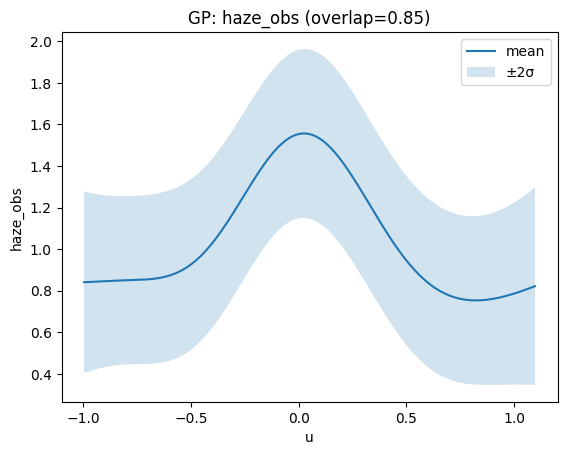

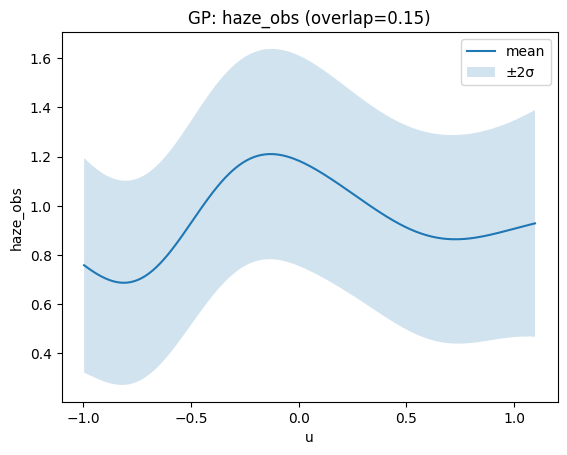

In [33]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

# サブサンプル（GPはO(n^3)）
n_gp = 450
sub = df2.sample(min(n_gp, len(df2)), random_state=0).copy()

Xgp = sub[["u", "overlap"]].to_numpy()
ygp = sub["haze_obs"].to_numpy()

# overlapをビン分け（qcutはカテゴリを返すが、以降はカテゴリに数値を入れない形で処理）
sub["over_bin"] = pd.qcut(sub["overlap"], q=6, duplicates="drop")

# ビンごとの分散（Seriesのまま持っておく）
var_by_bin = sub.groupby("over_bin", observed=False)["haze_obs"].var()

# map結果を最初から float 配列に落として NaN を数値で埋める（カテゴリに触れない）
alpha = sub["over_bin"].map(var_by_bin).to_numpy(dtype=float)
alpha = np.nan_to_num(alpha, nan=float(sub["haze_obs"].var()))
alpha = np.clip(alpha, 1e-6, None)

kernel = ConstantKernel(1.0) * RBF(length_scale=0.6) + WhiteKernel(noise_level=1e-2)
gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, normalize_y=True, random_state=0)
gp.fit(Xgp, ygp)
print("learned kernel:", gp.kernel_)

u_grid = np.linspace(df2["u"].min(), df2["u"].max(), 250)

def plot_slice(overlap_value):
    Xq = np.column_stack([u_grid, np.full_like(u_grid, overlap_value)])
    mu, std = gp.predict(Xq, return_std=True)

    fig, ax = plt.subplots()
    ax.plot(u_grid, mu, label="mean")
    ax.fill_between(u_grid, mu - 2 * std, mu + 2 * std, alpha=0.2, label="±2σ")
    ax.set_title(f"GP: haze_obs (overlap={overlap_value:.2f})")
    ax.set_xlabel("u")
    ax.set_ylabel("haze_obs")
    ax.legend()
    plt.show()

plot_slice(0.85)
plot_slice(0.15)



In [34]:
# GPの“面”を軽く可視化（plotly）
# 低解像度でOK
u_lin = np.linspace(df2["u"].min(), df2["u"].max(), 60)
o_lin = np.linspace(0.0, 1.0, 45)
U, O = np.meshgrid(u_lin, o_lin)
Xq = np.column_stack([U.ravel(), O.ravel()])
mu, std = gp.predict(Xq, return_std=True)
MU = mu.reshape(O.shape)
SD = std.reshape(O.shape)

fig = go.Figure(data=[go.Surface(x=U, y=O, z=MU)])
fig.update_layout(title="GP mean surface: haze_obs(u, overlap)",
                  scene=dict(xaxis_title="u", yaxis_title="overlap", zaxis_title="mean haze_obs"),
                  height=600)
fig.show()

fig = go.Figure(data=[go.Surface(x=U, y=O, z=SD)])
fig.update_layout(title="GP std surface: uncertainty(u, overlap)",
                  scene=dict(xaxis_title="u", yaxis_title="overlap", zaxis_title="std"),
                  height=600)
fig.show()


## 10) おまけ：PyTorchでポアソン（tabular）

「次はD2Lへ」という橋渡し用。  
Colabなら torch はだいたい入っています。


In [35]:
try:
    import torch
    import torch.nn as nn
    from torch.utils.data import TensorDataset, DataLoader

    d = df2.sample(min(1200, len(df2)), random_state=0).copy()
    feats = ["u","u2","overlap","depth_blue","f_white","f_blue","f_light","f_star","f_len"]
    X_t = torch.tensor(d[feats].to_numpy(), dtype=torch.float32)
    y_t = torch.tensor(d["star_count"].to_numpy(), dtype=torch.float32).view(-1,1)

    ds = TensorDataset(X_t, y_t)
    dl = DataLoader(ds, batch_size=64, shuffle=True)

    model = nn.Linear(X_t.shape[1], 1)
    loss_fn = nn.PoissonNLLLoss(log_input=False, full=True)
    opt = torch.optim.Adam(model.parameters(), lr=1e-2)

    for epoch in range(8):
        total = 0.0
        for xb, yb in dl:
            lam = torch.exp(model(xb)) + 1e-6
            loss = loss_fn(lam, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total += loss.item() * len(xb)
        print("epoch", epoch, "loss", total/len(ds))

    w = model.weight.detach().cpu().numpy().ravel()
    b = float(model.bias.detach().cpu().numpy().ravel()[0])
    print("bias", b)
    print(dict(zip(feats, w)))

except Exception as e:
    print("torch not available or failed:", e)


epoch 0 loss 22.46432940165202
epoch 1 loss 21.024003982543945
epoch 2 loss 19.410507202148438
epoch 3 loss 17.252922566731772
epoch 4 loss 14.612019284566243
epoch 5 loss 11.513342412312825
epoch 6 loss 8.14099998474121
epoch 7 loss 4.907822259267172
bias -0.0041251033544540405
{'u': np.float32(0.14142501), 'u2': np.float32(-0.09963079), 'overlap': np.float32(0.44907227), 'depth_blue': np.float32(-0.1582856), 'f_white': np.float32(-0.14693645), 'f_blue': np.float32(0.19112146), 'f_light': np.float32(0.48310015), 'f_star': np.float32(0.26221868), 'f_len': np.float32(-0.010790688)}


## メモ（ゆるめ）

- 線形回帰とポアソン回帰、どっちが「銀河っぽい」説明になる？
- overlap が小さいとき、GPの“幅”が増える？（増えてたらOK）
- 交互作用を入れると、何が分かりやすくなって、何が難しくなる？
- 外れ値は消す？読む？（ここが楽しい）
- もし星図が画像なら：CNN＋どんな損失にする？

以上！